In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
import keras
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation,Input,BatchNormalization,Add, AveragePooling2D ,Flatten,ReLU ,Add,Dense,Reshape,Multiply, Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

2.9.0


In [2]:
import hdf5storage
mat = hdf5storage.loadmat('D:/Projects/Anni apu/KU_har_time_freq_spectrogram_SP.mat')
data= mat['SP']
del mat
img_rows, img_cols = 8, 129
Channels = 12

In [3]:
df=pd.read_csv("D:/Projects/Anni apu/kuhar_labels.csv",header=None)
dff=df.values
y = dff[:,0]
num_classes = len(set(y))
print(num_classes)

18


In [4]:
x= np.array(data[: ,:, :, 0:6], dtype=np.float32)
#del data
print(x.shape)

(20750, 8, 129, 6)


In [5]:
X_train, X_test, y_train, y_test= train_test_split(x,y,test_size=0.25,random_state=9,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(max(y_train))
del x

(15562, 8, 129, 6)
(5188, 8, 129, 6)
17


In [6]:
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train)
y_test= to_categorical(y_test)
print(y_train.shape)

(15562, 18)


In [7]:
print(y_test.shape)

(5188, 18)


In [8]:
import tensorflow.keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def CBAM (x,r):
    
    ###### Channel Attention ##########
    f=x.shape[-1]
    a_pool = GlobalAveragePooling2D()(x)
    m_pool = GlobalMaxPool2D()(x) 
    Dense_layer1 = Dense (f // r , activation = 'relu') 
    Dense_layer2 = Dense (f, activation = 'relu') 
    avg_out = Dense_layer2 (Dense_layer1(a_pool)) 
    max_out = Dense_layer2 (Dense_layer1( m_pool))
    channel = add([ avg_out,max_out]) 
    channel = Activation('sigmoid') (channel) 
    channel = Reshape ((1,1,f)) (channel)  
    C_out = Multiply()([x,channel])
   
    
                      
    ###### Spatial Attention ########
    av_pooling=AveragePooling2D(pool_size=(1,1))(C_out)
    ma_pooling=MaxPooling2D(pool_size=(1,1))(C_out)
    spatial=concatenate([av_pooling,ma_pooling], axis = 3)
    spatial =Conv2D(1,(3,3),strides=1,padding ='same') (spatial) 
    #spatial=ASPP(x,spatial)
    
    spatial= Activation('sigmoid')(spatial)
      
    S_out = Multiply()([C_out,spatial])
    
    return S_out

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    
    
    
    x = Activation("relu")(x)
    return x

In [12]:
inputA = Input(shape=X_train[0].shape)


##### Channel 1 #########
s1 = conv_block(inputA,16)
a1=CBAM(s1,8)
pool1 = MaxPooling2D(pool_size=(2, 2))(s1)

s2 = conv_block(pool1,32)
s2=Dropout(0.1)(s2)
a2=CBAM(s2,8)



#pool2 = MaxPooling2D(pool_size=(2, 2))(a2)

s3 = conv_block(a2, 32)
s3=Dropout(0.1)(s3)
a3=CBAM(s3,8)


a33=Add()([a2,a3])
pool3 = MaxPooling2D(pool_size=(2, 2))(a33)

s4= conv_block(pool3,64)
s4=Dropout(0.15)(s4)
a4=CBAM(s4,8)

s5= conv_block(a4,64)
s5=Dropout(0.15)(s5)
a5=CBAM(s5,8)

a55=Add()([a4,a5])



pool5 = MaxPooling2D(pool_size=(2,2))(a55)

s6= conv_block(pool5,128)

s7=Dropout(0.15)(s6)

###### Concatenation ##############

F=Flatten()(s7)


x = Dense(128, activation="relu")(F)
x=Dropout(0.15)(x)

x = Dense(64, activation="relu")(F)
x=Dropout(0.15)(x)

x = Dense(48, activation="relu")(F)
x=Dropout(0.1)(x)

x = Dense(32, activation="relu")(x)



O = Dense(18, activation="softmax")(x)

model =  keras.Model(inputs=inputA, outputs=O)
opt = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt,  loss = 'mse', metrics = ['accuracy','precision_m', 'recall_m', 'f1_m'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 129, 6)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 129, 16)   880         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 8, 129, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 4, 64, 16)   0           ['activation[0][0]']             
                                                                                              

C:\Users\Khan\anaconda3\envs\gputest\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
model.save('D:/Projects/Anni apu/Signal.h5')

In [14]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('D:/Projects/Anni apu/Signal.h5',custom_objects={'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})
# summarize model.

In [15]:
history= model.fit(X_train, y_train, epochs=200,batch_size=32, validation_data=(X_test, y_test))


Epoch 1/200
487/487 [==============================] - 10s 11ms/step - loss: 0.0507 - accuracy: 0.2288 - precision_m: 0.3128 - recall_m: 0.0171 - f1_m: 0.0319 - val_loss: 0.0458 - val_accuracy: 0.3242 - val_precision_m: 0.5413 - val_recall_m: 0.0449 - val_f1_m: 0.0814
Epoch 2/200
487/487 [==============================] - 5s 10ms/step - loss: 0.0404 - accuracy: 0.4071 - precision_m: 0.6820 - recall_m: 0.1630 - f1_m: 0.2553 - val_loss: 0.0348 - val_accuracy: 0.4975 - val_precision_m: 0.8051 - val_recall_m: 0.2398 - val_f1_m: 0.3642
Epoch 3/200
487/487 [==============================] - 5s 10ms/step - loss: 0.0335 - accuracy: 0.5069 - precision_m: 0.7841 - recall_m: 0.3074 - f1_m: 0.4370 - val_loss: 0.0293 - val_accuracy: 0.6170 - val_precision_m: 0.8913 - val_recall_m: 0.3587 - val_f1_m: 0.5067
Epoch 4/200
487/487 [==============================] - 5s 10ms/step - loss: 0.0294 - accuracy: 0.5809 - precision_m: 0.8255 - recall_m: 0.3900 - f1_m: 0.5259 - val_loss: 0.0272 - val_accuracy: 0.

In [141]:
del model

In [16]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [17]:
from numpy import savetxt
savetxt('train_loss_LLD.csv', train_loss, delimiter=',')
savetxt('valid_loss_LLD.csv', valid_loss, delimiter=',')

savetxt('train_acc_LLD.csv', train_acc, delimiter=',')
savetxt('valid_acc_LLD.csv', valid_acc, delimiter=',')

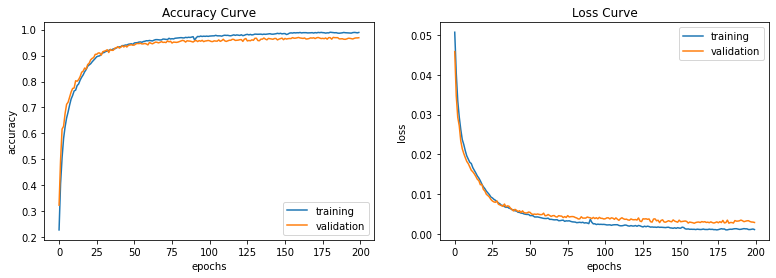

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [19]:
train_f1 = history.history['f1_m']
valid_f1 = history.history['val_f1_m']




In [20]:
from numpy import savetxt
savetxt('train_f1_m.csv', train_f1, delimiter=',')
savetxt('valid_f1_m.csv', valid_f1, delimiter=',')



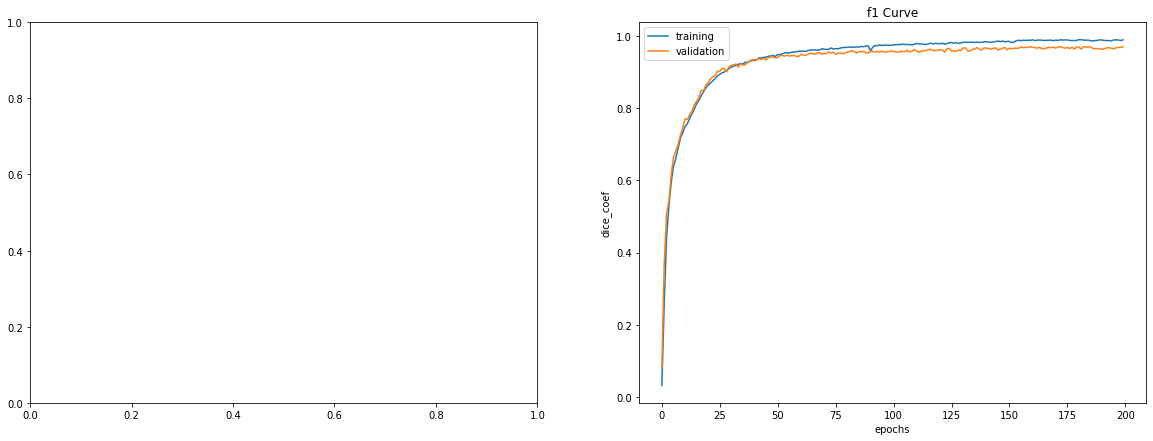

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()



axes[1].plot(train_f1, label='training')
axes[1].plot(valid_f1, label='validation')
axes[1].set_title('f1 Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

In [22]:
y_predict=model.predict(X_test)
y_pred=np.argmax(y_predict,axis=1)

163/163 [==============================] - 1s 3ms/step


In [24]:
y_test=np.argmax(y_test,axis=1)

In [25]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print(confusion_matrix)
savetxt('confusion_matrix.csv', confusion_matrix, delimiter=',')



[[459   8   3   1   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6 455   7   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  4   3 438   2   1   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 462   0   0   0   0   0   0   0   1   0   2   1   1   0   0]
 [  0   0   1   1 540   1   0   1   0   0   1   0   0   0   0   0   0   0]
 [  5   1   2   0   0 445   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3   4   1   1 426   4   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   2   7   0   5 317   0   0   0   0   0   0   0   1   0   1]
 [  0   0   0   0   0   0   0   0 166   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0 118   1   0   0   0   0   0   0   0]
 [  0   0   1   0  10   0   3   0   0   0 236   0   0   0   0   1   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0 210   7   1   0   1   0   0]
 [  1   0   0   3   0   0   0   0   0   0   0   1  74   0   0   0   0   0]
 [  0   0   0   1   0   0